# 国债期货

## 基础概念

国债期货作为利率期货的一个主要品种, 是基础的利率衍生品, 是指买卖双方通过有组织的交易场所, 约定在未来特定时间, 按预先确定的价格和数量进行券款交收的国债交易方式. 1976 年 1 月, 美国芝加哥商业交易所(CME)推出了 90 天期的国库券期货合约, 这标志着国债期货的正式诞生.

![利率期货的类别](./images/利率期货的类别.png)

国债期货的功能:
* 规避利率风险功能. 由于国债期货价格与其标的物的价格变动趋势基本一致, 通过国债期货套期保值交易可以避免因利率波动造成的资产损失.
* 价格发现功能. 国债期货价格发现功能主要表现在增加价格信息含量, 为收益率曲线的构造、 宏观调控提供预期信号.
* 促进国债发行功能. 国债期货为国债发行市场的承销商提供规避风险工具, 促进承销商积极参与国债一级和二级市场.
* 优化资产配置功能. 通过交易的杠杆效应, 国债期货具有较低的交易成本, 能够方便投资者调整组合久期、进行资产合理分配、提高投资收益率、方便现金流管理.

目前在中国金融期货交易所上市的国债期货有两只, 分别为 10 年期国债期货和 5 年期国债期货, 另外还即将上市 2 年期国债期货, 其合约的基本情况如下:

![10 年期国债期货合约表](./images/10年期国债期货合约表.png)

![5 年期国债期货合约表](./images/5年期国债期货合约表.png)

![2 年期国债期货合约表](./images/2年期国债期货合约表.png)

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
#%matplotlib notebook
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

,证券中文名称,上市日期,挂牌基准价,交割月份,最后交易日期,最后交割日
ID,,,,,,
T1803.CFE,10年期国债期货1803合约,20170612,94.9450,201803,20180309,20180314
T1806.CFE,10年期国债期货1806合约,20170911,95.1750,201806,20180608,20180613
T1809.CFE,10年期国债期货1809合约,20171211,92.9750,201809,20180914,20180919


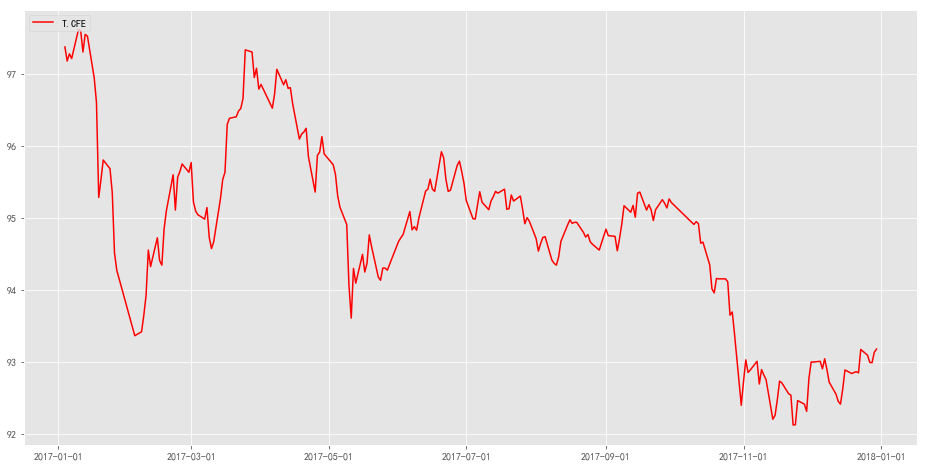

In [3]:
# --------参数设置---------
StartDT = dt.datetime(2017,1,1)
EndDT = dt.datetime(2017,12,31,23,59,59,999999)
FutureID = "T.CFE"# 主力合约, 10 年期国债期货

# --------准备数据--------
WDB.connect()
FT = WDB.getTable("中国国债期货交易日行情")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
Price = FT.readData(factor_names=["结算价(元)"], ids=[FutureID], dts=DTs).iloc[0,:,0]
FutureIDMap = WDB.getTable("中国期货连续(主力)合约和月合约映射表").readData(factor_names=["映射月合约Wind代码"], ids=[FutureID], dts=DTs).iloc[0,:,0]

# 具体的期货合约
FutureInfo = WDB.getTable("中国期货基本资料").readData(factor_names=["标准合约代码", "合约类型", "证券中文名称", "上市日期", "挂牌基准价", "交割月份", "最后交易日期", "最后交割日"], ids=FT.getID(idt=DTs[-1]), dts=[dt.datetime.today()]).iloc[:, 0, :]
FutureInfo = FutureInfo[FutureInfo["合约类型"]==1]
Mask = pd.Series(False, index=FutureInfo.index)
Mask = (FutureInfo["标准合约代码"]==FutureID.split(".")[0])
FutureInfo = FutureInfo[Mask].loc[:, ["证券中文名称", "上市日期", "挂牌基准价", "交割月份", "最后交易日期", "最后交割日"]]
display(FutureInfo)
WDB.disconnect()

# 绘制价格图像
Fig, Axes = plt.subplots(1, 1, figsize=(16, 8))
Axes.xaxis_date()
Axes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes.plot(Price.index, Price.values, color='r', label=FutureID)
Axes.legend(loc='upper left');

## 相关规则

### 交易

**报价方式**

10 年期和 5 年期国债期货以每百元面值国债作为报价单位，以**净价**方式报价。净价方式是指以不含自然增长应计利息的价格报价。


**交易方式**

采用集合竞价和连续竞价两种交易方式。
* 集合竞价时间为每个交易日 9:10-9:15，其中 9:10-9:14 为指令申报时间，9:14-9:15 为指令撮合时间。
* 连续竞价时间为每个交易日 9:15-11:30（第一节）和 13:00-15:15 （第二节），最后交易日连续竞价时间为 9:15-11:30。


**涨跌停**

每日价格最大波动限制是指其每日价格涨跌停板幅度，为上一交易日结算价的 ±2％。合约上市首日涨跌停板幅度为挂盘基准价的 ±4％。上市首日有成交的，于下一交易日恢复到合约规定的涨跌停板幅度；上市首日无成交的，下一交易日继续执行前一交易日的涨跌停板幅度。如上市首日连续三个交易日无成交的，交易所可以对挂盘基准价作适当调整。


### 保证金制度

随着交割月的临近, 国债期货的保证金会逐步提高.

![国债期货保证金](./images/国债期货保证金.png)

目前，中金所已在国债期货产品上开展了国债充抵保证金业务试点，并实施了跨期、 跨品种大边保证金制度，降低了投资者的资金成本。
* 国债作为保证金业务试点：符合条件的投资者， 可以将其持有的记账式附息国债，按照一定折抵比率(80%)充抵交易保证金
* 跨品种大边保证金：同一客户在同一会员处的同品种、跨品种双向持仓，交易所按照交易保证金单边较大者进行收取.


### 结算

**结算价**

合约最后一小时成交价格按照成交量加权的平均价, 如果合约最后一小时无成交的，以前一小时成交价格按照成交量加权的平均价作为当日结算价。该时段仍无成交的，则再往前推一小时，以此类推。合约当日最后一笔成交距开盘时间不足一小时的，则取全天成交量的加权平均价作为当日结算价。计算结果保留至小数点后 3 位.

当日盈亏 = \[ ∑(卖出成交价 - 当日结算价) × 卖出量 + ∑(当日结算价 - 买入成交价) × 买入量 + (上一交易日结算价 - 当日结算价) × (上一交易日卖出持仓量 - 上一交易日买入持仓量) \] × (合约面值 / 100)


**当日无负债结算制度**

当日无负债结算制度，其原则是当日交易结束后，交易所按当日结算价对结算会员结算所有合约的盈亏、交易保证金及手续费、税金等费用，对应收应付的款项实行净额一次划转，相应增加或减少结算准备金。

结算会员在交易所结算完成后，按照前款原则对客户、交易会员进行结算；交易会员按照前款原则对客户进行结算。

结算完毕后，结算会员的结算准备金余额低于最低余额标准时，该结算结果即视为交易所向结算会员发出的追加保证金通知，两者的差额即为追加保证金金额。


### 交割

国债期货采用 **实物交割** 方式进行交割，当合约到期进行实物交割时，可用于交割的债券包括一系列符合条件的国债品种，其票面利率、到期时间等各不相同。可交割国债和 **名义标准券** 之间的价格通过一个 **转换因子** 进行换算。

国债期货的交割分为两个阶段: **滚动交割**和**集中交割**. 
* 滚动交割: 合约进入交割月份后至最后交易日之前的这段时间为滚动交割阶段, 滚动交割阶段采用**空头举手**规则, 由卖方主动提出交割申报, 并由交易所组织匹配双方在规定的时间内完成交割.
* 集中交割: 在最后交易日收市后进入集中交割阶段, 交易所会自动匹配多空双方的持仓进行交割配对, 整个过程在三个交易日内完成.


**国债托管账户**

参与交割的客户应当事先通过会员向交易所申报国债托管账户. 在国债期货合约交割月份之前的二个交易日尚未通过国债托管账户审核的客户, 自交割月份之前的一个交易日至最后交易日, 其在该国债期货交割月份合约的持仓应当为 0, 否则交易所将对其强行平仓.


**交割流程**

交割在配对后的连续三个交易日内完成, 一般交割模式如下:
1. 第一交割日(交券日), 卖方确保交券的国债托管账户内有符合要求的可交割国债, 国债由卖方交券的国债托管账户划转至交易所的国债托管账户后视为卖方完成交券.
2. 第二交割日(配对缴款日), 当日结算时, 交易所将交割货款从买方(买方结算会员的结算准备金)划转至卖方(卖方结算会员的结算准备金), 同时释放进入交割的持仓占用保证金.
3. 第三交割日(收券日), 交易所将可交割国债划转至买方客户收券的国债托管账户.

![国债期货交割流程](./images/国债期货交割流程.png)

国债期货可交割券的划转涉及中金所与中债登、中证登上海分公司、中证登深圳分公司的业务交互:

![国债期货可交割券的划转](./images/国债期货可交割券的划转.png)

* 同市场交割: 卖方先把国债转入中金所在同一托管机构的债券账户，在券款交付后，再从中金所账户把国债划入买方在同一托管机构的账户

![国债期货同市场交割](./images/国债期货同市场交割.png)

* 跨市场交割: 通过中金所账户的转托管方式实现. 跨市场交割时，中金所账户作为桥梁，通过转托管业务将待交割国债由一个托管机构转至另一个托管机构，实现国债的跨市场过户.

![国债期货跨市场交割](./images/国债期货跨市场交割.png)


**交割结算价**

自交割月首日至最后交易日前一个交易日的交割结算价为当日结算价; 最后交易日的交割结算价为该合约最后交易日全部成交价格按照成交量加权的平均价. 计算结果保留至小数点后三位. 合约最后交易日无成交的, 交割结算价 = 该合约上一交易日结算价 + 基准合约当日结算价 - 基准合约上一交易日结算价, 其中, 基准合约为当日有成交的里交割月份最近的合约, 公式计算出的交割结算价超出合约涨跌停板价格的, 取涨跌停板价格作为交割结算价.


**名义标准券(虚拟标准券, Hypothetical Standardized Bond)**

指票面利率标准化、具有固定期限的假想券. 名义标准券设计的最大功能在于, 可以扩大可交割国债的范围, 增强价格的抗操纵性, 减小交割时的逼仓风险. 实物交割模式下, 如果期货合约的卖方没有在合约到期前平仓, 理论上需要用“名义标准券”去履约. 但现实中“名义标准券”并不存在, 因而交易所会规定, 现实中存在的、满足一定期限要求的一篮子国债均可进行交割.


**转换因子(Conversion Factor, CF)**

可交割债券和名义标准券之间的价格通过一个转换比例进行换算, 这个比例就是通常所说的转换因子. 转换因子的计算是面值 1 元的可交割国债在其剩余期限内的所有现金流量按国债期货合约票面利率向国债期货交割日进行贴现的现值, 国债期货转换因子的具体计算公式:
$$
CF=\frac{1}{(1+\frac{r}{f})^{\frac{xf}{12}}}\left[\frac{c}{f}+\frac{c}{r}\left(1-\frac{1}{(1+\frac{r}{f})^{n-1}}\right)+\frac{1}{(1+\frac{r}{f})^{n-1}}\right]-\frac{c}{f}\times\frac{12-fx}{12}
$$
其中:
$r$ 是国债期货标的票面利率; $x$ 为交割月距离下一个付息月的月份数(当交割月是付息月时, x=6 或 12); $n$ 表示剩余付息次数; $c$ 表示可交割券的票面利率; $f$ 表示可交割券每年的付息次数.

计算结果四舍五入至小数点后 4 位, 每个可交割债券的转换因子是固定不变的, 由中金所公布.

转换因子公式的推导:

先将未来现金流贴现到下一个付息日:
$$
\sum\limits_{i=0}^{n-1}\frac{c/f}{(1+r/f)^i}+\frac{1}{(1+r/f)^{n-1}} = \frac{c}{f}\frac{1-(\frac{1}{1+r/f})^n}{1-\frac{1}{1+r/f}}+\frac{1}{(1+r/f)^{n-1}} = \frac{c}{f}+\frac{c}{r}\left(1-\frac{1}{(1+\frac{r}{f})^{n-1}}\right)+\frac{1}{(1+\frac{r}{f})^{n-1}}
$$
再将所得的现金流贴现到交割月, 现值的计算以月为基本时间单位, 付息周期的月份数为 $\frac{12}{f}$, 从而以付息周期为单位的时间为 $\frac{x}{12/f}=
\frac{xf}{12}$:
$$
\frac{1}{(1+\frac{r}{f})^{\frac{xf}{12}}}\left[\frac{c}{f}+\frac{c}{r}\left(1-\frac{1}{(1+\frac{r}{f})^{n-1}}\right)+\frac{1}{(1+\frac{r}{f})^{n-1}}\right]
$$
最后再减去应计利息得到净价, 应计利息的计算也以月为基本时间单位, 其中交割月距离上一个付息月的月份数为 $\frac{12}{f}-x$, 从而应计利息为: 
$$
\frac{c}{f}\cdot\frac{\frac{12}{f}-x}{\frac{12}{f}} = \frac{c}{f}\frac{12-fx}{12}
$$

注: 严格的说，转换因子与交割日有关，但按照一般国际惯例，交割月内的转换因子人为统一，目前我国也采用这种模式.

经过转换因子的转换, 债券并没有实现真正意义上的标准化. 转换因子的假设前提是可交割债券的收益率在票面利率附近呈水平状, 并未考虑到期期限利差.


**应计利息(Accrued Interest)**

应计利息的日计数基准为“实际天数/实际天数”，每 100 元可交割国债的应计利息计算公式如下:

应计利息 ＝ 可交割国债票面利率 × 100 / 每年付息次数 × (配对缴款日 - 上一付息日) / 当前付息周期实际天数


**发票价格(Invoice Price)**

指到期交割日期货买方需要支付对应可交割券的价格:

发票价格 = 结算价 × 转换因子 + 应计利息


**交割货款**

国债期货合约交割时，卖方要向买方支付可交割债券，买方也要向卖方支付一定的金额，此金额即为交割货款。由于卖方选择用于交割的券种和交割时间不同，买方向其支付的金额也有差别。交割货款是以交割结算价为基础，按照不同可交割国债的转换因子和应计利息调整计算后得出。

交割货款 ＝ 交割数量 × 发票价格 × (合约面值 / 100) = 交割数量 × (交割结算价 × 转换因子 + 应计利息) × (合约面值 / 100)

### 风险管理

**持仓限额制度**

投机交易账户实行梯度降低持仓限额制度.

![国债期货持仓限额制度](./images/国债期货持仓限额制度.png)

套期保值和套利账户实行额度管理制度.

套期保值、套利额度分为产品额度和临近交割月份合约额度:
* 产品额度：同一产品各合约同一方向的套期保值或者套利最大持仓数量.
* 临近交割月份合约额度：临近交割月份合约某一方向的套期保值和套利最大持仓数量。额度自该合约交割月前一个月下旬的第一个交易日至该合约最后交易日期间有效.


**持仓报告制度**

达到下列标准的，投资者需要向交易所报告：
* 单个客户国债期货某一合约单边投机持仓达到交易所规定的投机持仓限额 80% 及以上的；
* 当全市场单边总持仓达到 5 万手时，单个客户国债期货单边总持仓占市场单边总持仓量超过 5% 的。


**强行平仓**

《中国金融期货交易所风险控制管理办法五种情况下会出现》规定，会员、客户出现下列情形之一的，交易所对其持仓实行强行平仓：

1. 结算会员结算准备金余额小于零，且未能在第一节结束前补足；
2. 客户、从事自营业务的交易会员持仓超出持仓限额标准，且未能在第一节结束前平仓；
3. 因违规、违约受到交易所强行平仓处罚；
4. 根据交易所的紧急措施应予强行平仓；
5. 交易所规定应当予以平仓的其他情形。

需要强行平仓的头寸先由会员自己执行，时限为开市后第一节交易时间。强行平仓的价格通过市场交易形成。若规定时限内会员未执行完毕，则由中金所强制执行。

强行平仓的执行程序为：

1. 通知。交易所以“强行平仓通知书”的形式向有关结算会员下达强行平仓要求。通知书随当日结算数据发送，有关结算会员可以通过交易所系统获得，交易所特别送达的除外。
2. 执行及确认。开市后，有关会员应当自行平仓，直至符合交易所规定；结算会员超过规定平仓时限而未执行完毕的，剩余部分由交易所执行强行平仓；强行平仓结果随当日成交记录发送，有关信息可以通过交易所系统获得。

## 相关费用

中金所 10 年期国债期货的相关费用

| 品种操作 | 手续费 | 期货公司净佣金 | 最低交易保证金 | 期货公司保证金 |
| ------- | ----- | ----------- | ------------ | ------------ |
| 开多仓 | 3 元/手 | - | 2% | - |
| 开空仓 | 3 元/手 | - | 2% | - |
| 平今仓 | 0 | - | - | - |
| 平老仓 | 3 元/手 | - | - | - |
| 交割 | 5 元/手 | - | - | - |

中金所 5 年期国债期货的相关费用

| 品种操作 | 手续费 | 期货公司净佣金 | 最低交易保证金 | 期货公司保证金 |
| ------- | ----- | ----------- | ------------ | ------------ |
| 开多仓 | 3 元/手 | - | 1.2% | - |
| 开空仓 | 3 元/手 | - | 1.2% | - |
| 平今仓 | 0 | - | - | - |
| 平老仓 | 3 元/手 | - | - | - |
| 交割 | 5 元/手 | - | - | - |

注:

1. 以上数据以 2018 年 7 月 23 日晚夜盘交易时起, 具体标准以交易所最新公布的结算参数为准(http://www.cffex.com.cn/jscs/).

## 理论定价

**符号说明**

* $t$: 当前时刻;
* $t^c_{-1}$: 上一次付息时刻;
* $t^c_1, t^c_2, ...$: 未来第一次, 第二次付息时刻;
* $T$: 期货到期日, 一般为第二交割日(缴款配对日);
* $C, c$: 息票金额, 票面利率;
* $f$: 每年的付息次数;
* $CF$: 转换因子;
* $AI$: 从上一付息日开始计算的应计利息, 则 $AI_t=C\cdot\frac{t-t^c_{-1}}{365}$
* $P$: 国债现货净价(面值等同于国债期货的面值);
* $P^d$: 国债现货全价, 则 $P^d_t = P_t+AI_t$
* $F$: 国债期货价格;
* $F^d$: 国债期货的发票价格, 则 $F^d_t = F_t\cdot CF+AI_T$


**隐含回购利率(Implied Repo Rate, IRR)**

隐含回购利率是指购买国债现货，卖空对应的期货，然后把国债现货用于期货交割，这样获得的理论收益率(不考虑国债期货合约所占有的保证金等资金占用因素)。

* 当前时刻到交割期间国债现货没有利息支付, 则计算公式为: 
$$
IRR_t = \frac{F^d_t-P^d_t}{P^d_t}\cdot\frac{365}{T-t}
$$

* 当前时刻到交割期间国债现货有利息支付, 还应该考虑到这个期货合约发票价格的融资利率，即持有该国债现货定期获得的利息收入进行再投资所获得的收入, 则隐含回购利率是下述方程的解: 
$$
IRR_t = \frac{F^d_t+\sum\limits_{t_i^c<T}\frac{C}{f}\cdot(1+IRR_t\frac{T-t^c_i}{365})-P^d_t}{P^d_t}\cdot\frac{365}{T-t}
$$

其中, 该公式假设得到的利息也以隐含回购利率进行再投资.
 
如果 IRR 高于投资者的资金成本，就可能存在套利机会。在无套利情况下，IRR 应等于资金成本。由于金融机构的短期资金成本多为回购利率，隐含回购利率因此而得名。


**最便宜可交割券(Cheapest to Deliver, CTD)**

在一篮子可交割债券制度下，剩余年限在一定范围内的国债都可以参与交割。由于收益率和剩余期限不同，可交割国债的价格也有差异。即使使用了转换因子进行折算，各种可交割国债之间仍然存在细微差别。一般情况下，由于卖方拥有交割券选择权，合约的卖方都会选择对他最有利，通常也是交割成本最低的债券进行交割， 对应的债券就是最便宜可交割国债。

理论上，一般可以通过比较不同券种的隐含回购利率寻找最便宜可交割债券, 一般来说，隐含回购利率最高的券就是最便宜可交割债券. CTD 是国债期货和现货的纽带.

CTD 变化的影响因素:
* 收益率曲线的波动(绝对水平和曲线形态)
* 新发国债带来的冲击
* 名义标准券票面利率的转变(几乎不发生)

在一定前提条件下, 通过比较久期和收益率可大致寻找最便宜可交割券：
1. 久期：对于收益率相同并且在名义标准券票面利率以下的债券而言, 久期最小的债券就是 CTD; 对于收益率相同并且在名义标准券票面利率以上的债券而言, 久期最大的债券就是 CTD.
2. 收益率：对具有同样久期的国债而言，收益率最高的国债是 CTD。

转换因子的计算是将每个可交割国债的“剩余价值”按照国债期货的名义票面利率 3% 的水平进行折现计算的。如果当前市场收益率正好等于 3%，那么这种方法计算比较“准确”。但是，如果实际收益率低于 3% 的话，则说明这个折扣率算高了，久期越长被多折算得越多，交割所支付的代价就越大，因此低久期的债券更加便宜；相反当收益率大于 3% 的时候就出现少折算了，这个时候久期越长就越划算，也就是高久期的债券更加便宜。当然，通常收益率曲线正常的话，不同久期债券和国债期货之间的价格存在如下如所示关系。

![国债期货 CTD 和久期](./images/国债期货CTD和久期.png)

**基差(Basis)**

现货价格与期货价格和转换因子乘积的差: 
$$
B_t = P_t − F_t\cdot CF
$$


**持有收益(Carry)**

持有收益指持有债券期间的利息收入减去资金成本. 资金成本可以是购买国债的资金来源的成本, 内部资金的成本, 或者机会成本. 如果持有收益是正的, 这和收益率曲线斜率为正的情况是类似的, 持有国债用于期货交割可以获得利息收入. 如果持有收益是负的, 则与收益率曲线斜率为负的情况类似, 投资者将损失利息收入. 

持有收益 = 利息收入 - 融资成本

利息收入 = $C\cdot\frac{T-t}{365}$

融资成本 = $P^d_t\cdot RP\frac{T-t}{365}=(P_t+AI_t)\cdot RP\frac{T-t}{365}$, 其中, $RP$ 是用来借入国债的融资利率, 比如回购利率或融券利率, 用来计算期货价值的正确回购利率是与当前距离交割日天数相一致的短期回购利率. 一般分析时可以使用 7 天质押式回购利率或者隔夜质押式回购利率. 

即:
$$
Carry_t = \left[C - (P_t+AI_t)\cdot RP\right]\frac{T-t}{365}
$$


**净基差(Basis Net of Carry, BNOC)**

度量考虑了成本的“买入现券+做空期货”的收益, 净基差 = 基差 - 持有收益, 即
$$
BNOC_t = B_t - Carry_t
$$


**持有成本模型**

期货价格 = 现货价格 + 期货空头持有现货的成本 - 期货空头持有现货的收益, 在不考虑期权价值的情况下, 国债期货的理论价格为:
$$
F_t = \frac{P_t - Carry_t}{CF}
$$
这里使用的现货是 CTD 券. 从而理论基差为:
$$
B_t = P_t − F_t\cdot CF = Carry_t
$$
而理论的净基差为:
$$
BNOC_t = B_t-Carry_t = 0
$$

In [11]:
TargetDT = DTs[-1]# 提取数据的目标时点
TargetFutureID = FutureIDMap.iloc[-1]
WDB.connect()
BondIDs = WDB.getTable("中国国债期货标的券", args={"回溯天数":366, "月合约Wind代码":TargetFutureID}).getID(ifactor_name="转换因子")
CF = WDB.getTable("中国国债期货标的券", args={"回溯天数":366, "月合约Wind代码":TargetFutureID}).readData(factor_names=["转换因子"], dts=[TargetDT], ids=BondIDs).iloc[0, 0, :]
CF = CF[pd.notnull(CF)]
BondIDs = CF.index.tolist()
BondInfo = WDB.getTable("中国债券基本资料").readData(factor_names=["债券名称", "交易所", "面值", "发行票面利率(%)", "付息频率", "付息日说明"], 
                                                  ids=BondIDs, dts=[TargetDT]).iloc[:, 0, :]
BondInfo["净价"] = WDB.getTable("中国债券行情-净价").readData(factor_names=["收盘价(元)"], ids=BondIDs, dts=[TargetDT]).iloc[0,0,:].values
BondInfo["全价"] = WDB.getTable("中国债券行情-全价").readData(factor_names=["收盘价(元)"], ids=BondIDs, dts=[TargetDT]).iloc[0,0,:].values
BondInfo = pd.merge(BondInfo, WDB.getTable("中国债券行情-净价").readData(factor_names=["成交量(手)", "成交金额(千元)"], ids=BondIDs, dts=DTs[-20:]).mean(), left_index=True, right_index=True)
BondInfo["转换因子"] = CF
BondInfo = pd.merge(BondInfo, WDB.getTable("中国债券应计利息").readData(factor_names=["已计息时间", "应计利息"], dts=[TargetDT], ids=BondIDs).iloc[:,0,:], left_index=True, right_index=True)
BondInfo = pd.merge(BondInfo, WDB.getTable("中国国债期货可交割券衍生指标", args={"月合约Wind代码":TargetFutureID}).readData(factor_names=["区间利息", "交割利息", "IRR", "基差"], dts=[TargetDT], ids=BondIDs).iloc[:,0,:], left_index=True, right_index=True)
BondInfo.insert(loc=BondInfo.shape[1]-2, column="发票价格", value=(CF * Price.loc[TargetDT] + BondInfo["交割利息"]).values)
RP = WDB.getTable("货币市场日行情").readData(factor_names=["加权平均利率"], ids=["DR007.IB"], dts=[TargetDT]).iloc[0,0,0]# 资金成本取银行间 7 天质押式回购利率
Mask = pd.notnull(BondInfo["区间利息"])
BondInfo["Carry"] = np.nan
SettlementDayNum = (dt.datetime.strptime(FutureInfo.loc[TargetFutureID, "最后交易日期"], "%Y%m%d").date() - TargetDT.date()).days + 4
BondInfo["Carry"][Mask] = (BondInfo["交割利息"] + BondInfo["区间利息"] - BondInfo["全价"]*RP/100/365*SettlementDayNum)[Mask]
BondInfo["Carry"][~Mask] = (BondInfo["交割利息"] - BondInfo["应计利息"] - BondInfo["全价"]*RP/100/365*SettlementDayNum)[~Mask]
BondInfo["BNOC"] = BondInfo["基差"] - BondInfo["Carry"]
WDB.disconnect()
display(BondInfo.sort_values(ascending=False, by=["IRR"]))

,债券名称,交易所,面值,发行票面利率(%),付息频率,付息日说明,净价,全价,成交量(手),成交金额(千元),转换因子,已计息时间,应计利息,区间利息,交割利息,发票价格,IRR,基差,Carry,BNOC
ID,,,,,,,,,,,,,,,,,,,,
010713.SH,2007记账式十三期国债,SSE,100,4.5200,M6,"每年8月16日和2月16日付息,节假日顺延",100.0000,101.684164,0.000000,0.000000e+00,1.1239,136.0,1.684164,2.260,0.312155,105.031537,27.8178,-4.7194,1.934891,-6.654291
100713.SZ,2007记账式十三期国债,SZSE,100,4.5200,M6,"每年8月16日和2月16日付息,节假日顺延",100.0000,101.684164,0.000000,0.000000e+00,1.1239,136.0,1.684164,2.260,0.312155,105.031537,27.8178,-4.7194,1.934891,-6.654291
070013.IB,2007记账式十三期国债,NIB,100,4.5200,M6,"每年8月16日和2月16日付息,节假日顺延",103.3984,105.056552,1500.000000,1.551478e+04,1.1239,135.0,1.658152,2.260,0.312155,105.031537,10.7236,-1.3210,1.913756,-3.234756
160017.IB,2016年记账式附息(十七期)国债,NIB,100,2.7400,M6,"每年8月4日和2月4日付息,节假日顺延",90.6529,91.747411,69345.000000,6.292716e+05,0.9808,147.0,1.094511,1.370,0.280055,91.666095,7.0332,-0.7331,1.075066,-1.808166
019564.SH,2017年记账式附息(十期)国债,SSE,100,3.5200,M6,"每年5月4日和11月4日付息,节假日顺延",96.3900,96.930055,0.000000,0.000000e+00,1.0414,56.0,0.540055,NaN,1.254365,98.286810,6.9038,-0.6424,0.106840,-0.749240
160010.IB,2016年记账式附息(十期)国债,NIB,100,2.9000,M6,"每年5月5日和11月5日付息,节假日顺延",91.8387,92.271297,69185.000000,6.361988e+05,0.9928,54.0,0.432597,NaN,1.025414,93.529554,6.7263,-0.6654,0.014545,-0.679945
160023.IB,2016年记账式附息(二十三期)国债,NIB,100,2.7000,M6,"每年11月3日和5月3日付息,节假日顺延",90.3754,90.793080,47955.000000,4.341392e+05,0.9772,56.0,0.417680,NaN,0.969613,92.020223,6.6664,-0.6752,-0.017075,-0.658125
019572.SH,2017年记账式附息(十八期)国债,SSE,100,3.5900,M6,"每年2月3日和8月3日付息,节假日顺延",97.0700,98.535507,0.000000,0.000000e+00,1.0481,149.0,1.465507,1.795,0.376851,98.033568,6.5930,-0.5867,1.554320,-2.141020
101516.SZ,2015年记账式附息(十六期)国债,SZSE,100,3.5100,M6,"每年1月16日和7月16日付息,节假日顺延",95.8880,97.493945,0.180000,1.754750e-01,1.0333,167.0,1.605945,1.755,0.542983,96.820711,5.5734,-0.3897,1.686980,-2.076680


**交割期权**

国债期货交割中所隐含的期权大致可以分为两类：一类是交割对象的选择权, 即利率结构变动造成的最终 CTD 的变换；另一类是交割时间的选择权, 即由于空方能在不同时间选择交割而拥有的时间性期权。对于这两大类的期权，我们可以粗略的按照美式期权的概念来理解，即国债期货的交割期权既有欧式期权的特性，也有美式相对于欧式的溢价, 体现为提前(甚至延后)交割溢价。

![交割期权](./images/交割期权.png)

**转换期权(质量期权, Quality Option)**

空头可以选择对自己有利的国债参与交割的权利.


**时机期权**

空头可以选择在交割月份最后交易日之前的任一交易日进行交割的权利, 即空头举手. 由于中金所合约规定最后交易日为交割月第二个星期五，且交割申请过程需要 4 天，实际仅有 6 个交易日可以选择，因此时机期权有限；美国约有 20 日左右的申报时间。


**月末期权**

指由于期货最后交易日之后距离最后交割日仍有一定时间，使得期货空头有权根据现货市场变动调整交割券种而产生的期权。美国有 7 个交易日，中国仅有 3 个，因此月末期权价值有限。 


**百搭牌期权**

指期货交易结束后，现货交易仍未结束带来空头额外的购券时间。美国期货市场止于下午 2 点，现货止于 4 点，有 2 个小时的百搭牌时间，而中国期货止于下午 3 点 15 分，银行间止于 4 点 30 分，交易所止于 3 点，因此，百搭牌期权几乎不存在。


由于制度安排, 我国国债期货有价值的交割期权主要为转换期权. 考虑到空头持有的期权价值, 则国债期货的理论价格为:
$$
F_t = \frac{P_t - Carry_t - Option_t}{CF}
$$
其中, $Option_t$ 是空方持有的交割期权的理论价值, 这里使用的现货是 CTD 券, 从而理论基差为:
$$
B_t = P_t − F_t\cdot CF = Carry_t + Option_t
$$
而理论净基差为:
$$
BNOC_t = B_t-Carry_t = Option_t
$$

**期权调整基差(Option Adjusted Basis, OAB)**

$$
OAB_t = BNOC_t - Option_t
$$
理论上期权调整基差为 0.


### 交割期权定价的文献综述

对于空头拥有的交割期权(主要是质量期权)的定价, 主要方法有以下四类:

**已实现期权价值法(Payoff 法)**

基本思路是利用历史的真实交割数据计算已实现质量期权价值。所谓“已实现”是指基于历史的真实数据进行回溯，假设期货空方在到期前已经买入某一债券，再计算期货到期时，空方更换为最合算的 CTD 券进行交割所得到的额外回报，如 Hegde(1990) 和 Hemler(1990)。

已实现期权价值法的最大优点是不需要对债券价格和利率过程做任何假定，可以从一个侧面来研究历史上质量期权价值占国债期货价格的比例，例如 Hemler(1990)发现 1977—1986 年间美国长期国债已实现质量期权的价值大约占期货面值的 0.2%。这类方法存在两个不足: 第一，为了保证得到的结果具有统计意义，此方法需要一段足够长时间的真实到期交割数据作为研究样本; 第二，该方法只能计算得到质量期权价值的历史表现，并不能用于国债期货和质量期权的实时定价。


**隐含期权价值法**

基本思路是利用历史的真实成交价格数据倒推市场隐含的质量期权价值。该方法运用前面介绍的持有成本模型计算出不含质量期权的国债期货价格，再计算其与国债期货的市场价格之差，认为就是市场隐含的质量期权价值，如 Gay 等(1984) 和 Hemler(1990)。Hemler(1990) 发现用此方法计算得到的 1977—1986 年间美国长期国债期货隐含质量期权的价值大约为期货面值的 0.3%.

与“已实现期权价值法” 一样，“隐含期权价值法”也不需要对债券价格和利率过程做任何设定; 但“隐含期权价值法”可以利用每个时刻的国债期货成交价格，而不像与“已实现期权价值法”那样只能利用到期日的交割数据，因此对数据的要求较低。然而，“隐含期权价值法”的一个重要缺陷是，由于市场价格中存在噪音，很难确定该方法得到的究竟真是质量期权价值，还是其他期权的价值、定价偏误或计算误差。另外，该方法依然只能计算出质量期权价值的历史表现，不能用于国债期货的实时定价。


**静态复制法**

基本思路是将国债期货中的质量期权表达为某些市场上有交易的利率期权的组合，从而计算出质量期权的价值。Boyle(1989) 和 Balbas 等(2010) 是典型代表。Boyle(1989)的做法是: 将含有质量期权的期货合约拆分为以下两个资产的组合: 标的资产为期货合约中规定的可交割券中最便宜的债券、执行价格为 0 的一个欧式看涨期权多头和一个欧式看跌期权空头，由此得到期货的均衡价格实际上相当于此欧式看涨期权当前的价格与 $e^{r(T-t)}$ 的乘积，其中 T－t 为从定价时刻到期货到期日的剩余时间，r 为此期限相应的无风险(连续复利)利率。该文章假设各可交割资产收益率(连续复利)的方差协方差矩阵服从多元正态分布，并在假设所有资产的初始价格、收益率标准差以及收益率相关系数都相同的情况下，发现可交割资产的数量越多，期货价格越低，也就是质量期权的价值越高; 收益率之间的相关系数越大，期货价格越高，也就是质量期权的价值越低。Balbas 等(2010)同样利用资产组合静态复制的方法，使用含有质量期权的期货合约的看涨期权和看跌期权来复制期货合约内含的质量期权，文章还给出了存在市场摩擦时质量期权价值的范围。

静态复制法直接利用市场数据为质量期权定价，可以规避模型风险和参数风险，但要求所需的利率衍生品在市场上有交易，并且市场价格合理。


**联合分布法**

基本思路是通过估计债券价格或利率的未来联合分布来确定质量期权和国债期货的价格。研究又大致分为三种做法:


**资产交换期权法**

在国债期货交割时，空方执行质量期权实际上相当于将其他债券置换为 CTD 券进行交割，因此将质量期权视为一种多资产的交换期权是很自然的想法。而对于资产交换期权，在某些特定的随机过程下(主要是联合几何布朗运动)，我们可以获得期权价值的解析解。这使得这一方法看上去非常有吸引力，主要相关文献包括 Margrabe(1978)、Gay 等(1984) 和 Hemler(1990) 等。Margrabe(1978) 在 BSM 期权定价模型的基础上导出了两种无红利资产的交换期权定价公式，这个定价公式的本质是将 BSM 期权定价公式中确定的执行价格 K 替换为另一种资产的价格。Gay 等(1984) 使用此交换期权定价公式对小麦期货中的质量期权进行了定价。他们假设只有两种可供选择的交割对象，所有交割对象都具有相同且非随机的储藏成本，利率非随机，忽略时间期权和地域期权，无税收。实证分析表明质量期权对小麦期货价格的影响很大，保守估计至少有 2.2%。Hemler(1990) 假设国债期货的可交割券集的价格服从联合几何布朗运动，市场是完美的，忽略远期与期货之间的差别，同时假设所有交易者均选择同一天进行交割，即忽略时间期权，在此基础上导出了国债期货质量期权的定价公式。在可交割券数量为 2 和 3 的情况下，Hemler(1990) 利用此定价公式得到 1977 年至 1986 间质量期权的价值占美国国债期货价格的比例大约为 0.7% 至 1.2%。

由于在几何布朗运动的假设下可以得到资产交换期权的解析解，资产交换期权法使用时比较简单。但其不足之处也相当明显: 首先，资产交换期权法只有在联合几何布朗运动的假设下才能得到解析解，但由于债券价格到期收敛于面值，具有布朗桥的性质，几何布朗运动的假设并不合理。其次，资产交换期权法在具体使用时需要较大的计算量，因为国债期货的标的资产多达数十个，这意味着需要估计一个庞大的方差协方差矩阵，在计算公式中还包含有一个和可交割券数量具有大体相同重数的复杂多重积分。


**动态利率模型法**

由于债券价格的随机过程不易设定，研究者们开始转向设定利率所服从的随机过程，以此推断期货到期时可交割券价格的联合分布，进而估计质量期权的价值。相关文献包括 Kane 等(1986)、Ritchken(1992)、Bick(1997)、Carr 等(1997)、Chen 等(2005)、 Rendleman(2004)、Nunes 等(2007)、Ritchten 等(1995) 和 Ben－Abdallah 等(2012)。

Kane 等(1986) 和 Ritchken(1992) 是该方法的早期文献。Ritchken(1992) 设定了远期利率的随机过程，其中波动项被设定为指数形式的 $\sigma e^{-\kappa(T-t)}$。在这种设定下，即期利率未来的风险中性分布为正态分布。当所有可交割券都是零息债时，文章给出了国债期货价格的解析解。当可交割券中含有附息债时，解析解将变得非常复杂，但是可以用分位数的方式计算债券价格期望值的数值解，确定未来的 CTD 券并得到国债期货的价格。Kane 等(1986) 则构造了一个由债券的剩余期限和息票率作为因子的利率期限结构模型，在实证部分首先由 1978 年至 1982 年间的历史数据估计得到参数之间的相关系数和标准差，然后以期货到期前 3 个月的实际利率期限结构作为初值进行 Monte－Carlo 模拟，得到了 10000 种未来可能的利率期限结构情形，并由此确定每一种情形下的 CTD 券，得到质量期权的价值。该文章发现，由此得到的 3 个月质量期权价值至少是国债期货价格的 2% 到 6%。随着动态利率模型理论的发展，一些常见的动态利率模型被运用到质量期权的定价中来，包括 Vasicek 模型、CIR 模型、BDT 模型和 HJM 模型。其中，Bick(1997) 假设无风险利率的随机过程服从 Vasicek 模型，由此得到两种情形下含有质量期权的期货价格的闭式解，一种情形的标的资产为 n 只不同到期期限的零息债，另一种情形的标的资产是 n 种商品。对于前一种情形，期货价格的解的形式类似于这 n 个零息债各自的期货价格的某种加权平均。文章将权重系数解释为等价于一种动态的策略，这种策略利用单个零息债的期货合约复制了含有质量期权的期货合约每一瞬间的现金流变化。Carr 等(1997) 是使用单因子 CIR 模型的典型文献，该文通过对瞬时利率建模，得到了国债期货价格以及质量期权价值的解析解。这个解析解是在假设将未来的即期利率分成多个区间，而每个区间对应于不同的最便宜可交割债券的基础上得到的。该文章发现，得到的国债期货价格的解可以视为所有可交割债券现券价格的一个加权组合，也可以视为所有可交割债券期货价格的一个加权组合。作者将权重系数解释为某只债券将会成为最便宜可交割券的风险中性概率。这也同时意味着，国债期货多头的一方可以通过卖空现券组合或是现券期货组合来复制国债期货，实现完全套保。文章还利用短期利率和长期利率因子建立了双因子模型，两个因子均服从 Vasicek 过程，并用双因子模型进行了实证分析。对 1987—1991 年美国国债期货的实证结果表明质量期权对国债期货价格的影响很大，因此双因子模型和传统的持有成本模型得到的结果具有很大的区别。同样
使用 CIR 模型的还有 Chen 等(2005)。Rendleman(2004) 使用 BDT 模型对国债期货及其内含的质量期权进行定价。文章假设利率期限结构和波动率期限结构均为水平，对 2002 年 2 月份开始到 2003 年 2 月份交割的美国国债期货的实证结果表明，当即期利率十分接近于美国国债期货虚拟券的到期收益率 6% 时，质量期权的价值很大，此时最优套期保值比率会大幅偏离于基于传统久期得到的套期保值比率，当即期利率远离 6% 时，则可以不需要考虑质量期权对套期保值比率的影响。Nunes 等(2007) 利用 HJM 模型，在条件近似和一阶近似的情况下得到了质量期权价值的解析解，这种方法在任何可交割资产以及任意维数的 HJM 模型下均可使用。得到的国债期货的价格可以写为单个零息债期货价格的一种加权平均的形式，权重系数中仅含有一维正态分布概率密度函数。在实证部分，该文首先使用 Monte－Carlo 方法进行测试，发现解析解和模拟的结果之间的差距非常小，小于 1 个基点。最后作者用三因子 HJM 模型对从 1999 年 3 月到 2001 年 9 月在 EUREX 交易的德国国债期货进行了研究，发现解析解和真实的市场价格非常接近，日均差距的绝对值不超过 8 个基点。而质量期权占国债期货价格的比例非常小，平均不超过 5 个基点，几乎可以忽略不计。同样使用 HJM 模型的还有 Ritchken 等(1995) 和 Lin 等(1995)。Ben－Abdallah 等 (2012) 则给出了一种对美国长期国债期货定价的数值方法。这种方法考虑了美国长期国债期货合约的所有特征，包括质量期权、百搭牌期权、月末期权在内的所有期权及其相互作用，以及长达三天的交割流程中各个重要时间点的区分。文中将每一个时间点期货合约的价值用一个值函数来表示，通过比较不同债券执行价值的大小来决定 CTD 券，通过比较持有价值和执行价值来决定在某个时间点是否交割，通过逆推得到当前合理的期货价格。为了减少计算量，作者将状态空间划分为具有有限数量格点的网格，并用线性插值法来进行近似得到值函数的值。文章使用 Vasicek 模型、CIR 模型和 Hull－White 模型进行了实证。其中 Hull－White 模型的参数用 Vasicek 模型和极大似然估计进行校准，市场 t 时刻的瞬时利率使用 NS 模型得到。实证结果表明理论期货价格平均比真实期货价格高 2%，这说明市场有可能高估了交割期权的价值。同时还发现市场高估交割期权价值时，收益率曲线的斜率为正且很大，低估交割期权价值时，收益率曲线则接近平坦。这篇文章是所有文献中做得最翔实的一篇，但其最大的不足之处是假设债券以一个固定的息票率连续付息，由此替代真实的付息日和付息频率，这与现实不符。

“动态利率模型法” 克服了“资产交换期权法” 的两个主要缺点: 假设可交割券价格服从联合几何布朗运动; 可交割券的维度太高，从理论上说是为国债期货和质量期权定价的最合理方法。但“动态利率模型法” 相当复杂，而且具有较大的模型风险和参数选择风险，在具体使用时，需要对具体动态模型的准确性、合理性和可操作性进行权衡和选择。


**情景模拟法**

在 Burghardt 等(2005) 的专著中提到了一种“情景模拟法”，该方法主要为业界采用。其基本思路是，根据历史经验和主观判断，推断到期收益率曲线未来可能的变化情景和发生概率，判断各种情景下的 CTD 券，相应计算质量期权价值。“情景模拟法”显然也是联合分布法的一种，操作过程相对简单易于理解，但其准确性显然依赖于操作者对未来分布的人为判断，具有较大的主观性和不精确性。